### Neural Network (from Scratch)
- [Source](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/)
- [Main](http://cs231n.github.io/neural-networks-case-study/)

In [1]:
import numpy as np
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10.0, 8.0)

#### Generate a dataset and plot it

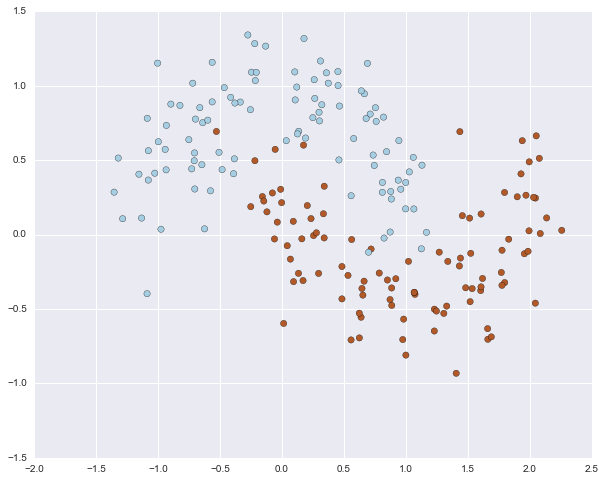

In [2]:
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.figure(figsize = (10, 8))
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Paired)

In [3]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [4]:
# Helper function to plot decision boundary
def plot_decision_boundary(predict_function):
    
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(x_min, x_max, h))
    
    # Predict the function value for the whole grid
    # numpy.c_ - Translates slice objects to concatenation along the second axis
    Z = predict_function(np.c_[xx.ravel(), yy.ravel()]) # numpy.ravel - Flattens an array
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training example
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.75)
    plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Paired)

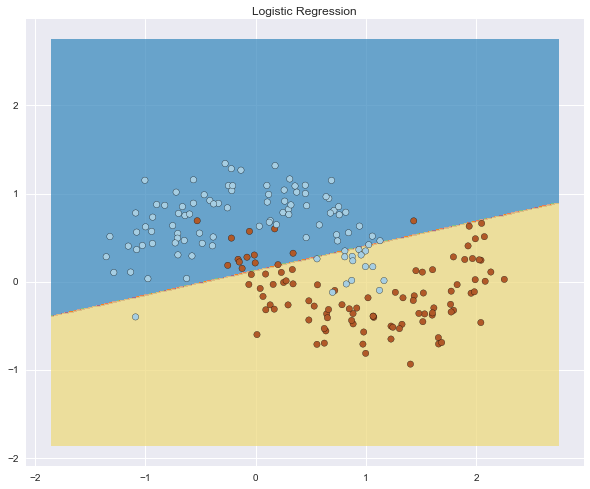

In [5]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title('Logistic Regression')

#### Implementation

In [6]:
# Training set size
num_examples = len(X) 

# Input layer dimension
nn_input_dim = 2

# Output layer dimension
nn_output_dim = 2

# Gradient descent parameters
epsilon = 0.01
reg_lambda = 0.01

In [7]:
# Matrix Products for Neural Networks

# Class array of size r = 10, c = 1
y_ = np.array([1, 0, 0, 1, 1, 1, 0, 0, 1, 0])
print 'y dimensions: ', y_.shape
# Data Matrix x of size r = 10, c = 2
x = np.array(np.random.randn(20)).reshape(10,2)
print 'x dimensions: ', x.shape
# Weight Matrix w of size r = 2, c = 2
w = np.array(np.random.randn(4)).reshape(2, 2)
print 'w dimensions: ', w.shape
# Dot product matrix z of size r = 10, c = 3, z[i, j] = x[i,:] . w[:,j]
z = x.dot(w)
print 'z dimensions: ', z.shape
# Bias vector size: r = 1, c = 2
b = np.zeros((1, 2))
print 'b dimension: ', b.shape
# Probabilities using softmax
p = np.exp(z)/np.sum(np.exp(z), axis=1, keepdims=True)
print 'p dimensions: ', p.shape

# Numpy Array Summation
print '\nArray summation'
s = np.array([[1, 2, 3], [4, 5, 6]])
print 'Sum of all elements: ', np.sum(s)
print 'Sum of all rows (axis=0): ', np.sum(s, axis=0)
print 'Sum of all columns (axis=1): ', np.sum(s, axis=1)

y dimensions:  (10,)
x dimensions:  (10, 2)
w dimensions:  (2, 2)
z dimensions:  (10, 2)
b dimension:  (1, 2)
p dimensions:  (10, 2)

Array summation
Sum of all elements:  21
Sum of all rows (axis=0):  [5 7 9]
Sum of all columns (axis=1):  [ 6 15]


In [8]:
# Function to evaluate the total loss on the dataset
def calculate_log_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    # Calculate Probabilities using softmax
    probs = np.exp(z2)/np.sum(np.exp(z2), axis=1, keepdims=True)
    # Calculate log probabilities of correct class
    correct_log_probs = np.log(probs[range(num_examples), y])
    data_loss = -np.sum(correct_log_probs) # Binary!
    # Adding regularization term to loss
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1.0/num_examples * data_loss

In [9]:
# Function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = np.exp(z2)/np.sum(np.exp(z2), axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [10]:
# Function to create neural network and learn its parameters
def build_nn_model(nn_hdim, num_passes=20000, print_loss=False):
    '''
    nn_hdim: Number of nodes in hidden layer
    num_passes: Number of passes through training data for gradient descent
    '''
    #---- Initialize the parameters to random values ----
    np.random.seed(0)
    # W1 dim: r = input layer dim, c = hidden layer dim
    W1 = np.random.randn(nn_input_dim, nn_hdim)/np.sqrt(nn_input_dim)
    # b1 dim: r = 1, c = hidden layer dim
    b1 = np.zeros((1, nn_hdim))
    # W2 dim: r = hidden layer dim, c = output layer dim
    W2 = np.random.randn(nn_hdim, nn_output_dim)/np.sqrt(nn_hdim)
    # b2 dim: r = 1, c = output layer dim
    b2 = np.zeros((1, nn_output_dim))
    
    # ---- Dict to return model ----
    model = {}
    
    # ---- Gradient descent for each batch ----
    for i in xrange(0, num_passes):
        # -- Forward propagation --
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        probs = np.exp(z2)/np.sum(np.exp(z2), axis=1, keepdims=True)
        
        # -- Reverse propagation -- Need to understand this
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1-np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        # -- Add regularization terms --
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        
        # -- Gradient Descent parameter update --
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # -- Assign new parameters to the model --
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # -- Print loss (optional) --
        if print_loss and i % 1000 == 0:
            print 'Loss after iteration {}: {}'.format(i, calculate_log_loss(model))
        
        return model

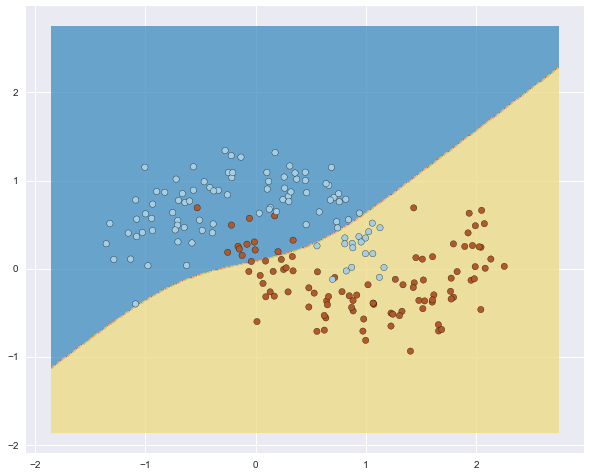

In [11]:
model = build_nn_model(3)
plot_decision_boundary(lambda x: predict(model, x))

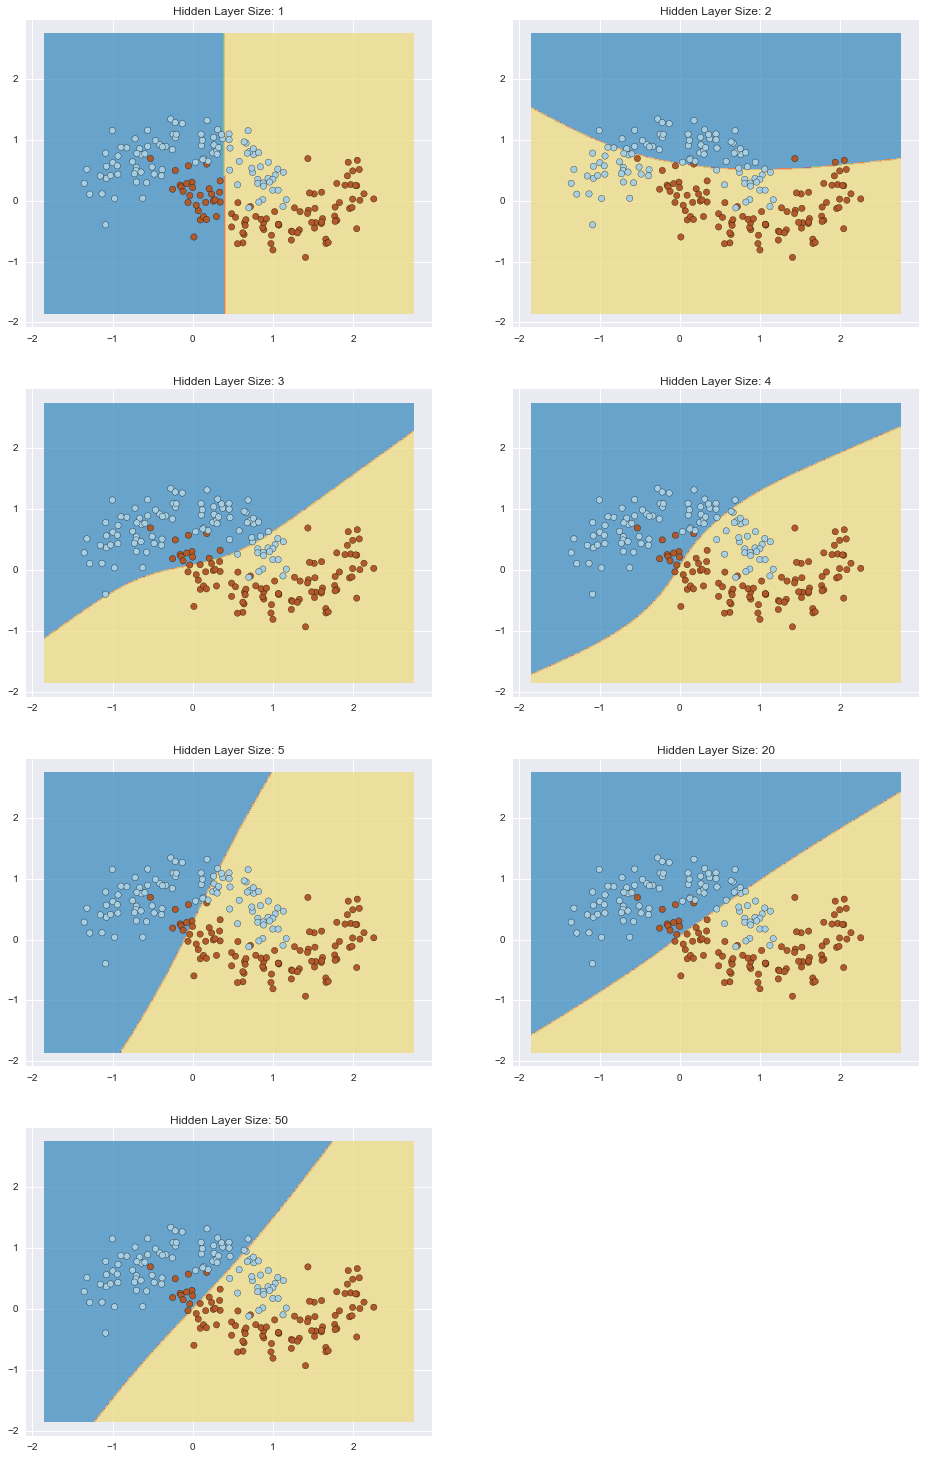

In [12]:
plt.figure(figsize=(16,32))
hidden_layer_dims = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dims):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer Size: %d' % nn_hdim)
    model = build_nn_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()